In [1]:
import numpy as np
import scipy.stats as sstats
from matplotlib import pyplot as plt
import ipywidgets as wid

In [2]:
def linmat(alpha=1, beta=1, M=1): # underdetermined 2 to 1 
    Q_map = np.array( [[alpha, beta]] )
    Q_map = np.tile(Q_map.T, M).T
    return Q_map

def gauss_sol(prior_mean, prior_std, data_std, A, data): # DO NOTE THAT SIZES HERE ARE Column-Major instead of Row-Major ... (dim, samps)
    if type(prior_mean) is int:
        prior_mean = [prior_mean, prior_mean]
    if type(prior_mean) is float:
        prior_mean = [prior_mean, prior_mean]
    if type(prior_mean) is list:
        prior_mean = np.array(prior_mean).reshape(-1,1)
    if type(prior_std) is list:
        prior_std = np.array(prior_std).reshape(-1,1)
    if type(data_std) is list:
        data_std = np.array(data_std).reshape(-1,1)
    prior_cov = prior_std*prior_std*np.eye(2) 
    data_cov = data_std*data_std*np.eye(len(data_std)) 
    
    ASA = A@prior_cov@A.T
    
    precision = np.linalg.inv(ASA + data_cov)
    kahlman_update = (prior_cov@A.T@precision)
    post_mean = prior_mean + kahlman_update@(data - A@prior_mean)
    post_cov = prior_cov - kahlman_update@A@prior_cov
    
    return prior_mean, prior_cov, post_mean, post_cov


In [46]:
# THIS EXAMPLE HAS FIXED INPUT AND OUTPUT DIMENSION (2 to 1)

def solve_problem(num_samples = 1000,
                num_observations = 3,
                alpha = 1, 
                beta = 1, 
                data_val = 0,
                data_std = 0.25,
                prior_std_1 = 1,
                prior_std_2 = 1,
                seed=1,
                plot=True):
    prior_mean = 0
    prior_std = np.array([prior_std_1, prior_std_2])
    ## define distributions
    
    initial_dist = sstats.distributions.norm(loc=np.zeros(2), scale=prior_std)
    observed_dist = sstats.distributions.norm()
    np.random.seed(seed)
    ## define map and data
    A = linmat(alpha, beta, M=num_observations)
    # instead of defining lambda_true and propagating it, we will just pick a fixed datum and hit it with noise
    noise = np.random.randn(num_observations).reshape(1,-1)
    np.random.seed(seed+3)
    data = data_val + noise

    # generate samples
    input_samples = initial_dist.rvs((num_samples,2))
    output_samples = input_samples@A.T # SIZE = num_samples x num_observations

    def misfit(samples, data, std): # 1-D misfit
        return (1./std)*(1./np.sqrt(len(data)))*np.sum( samples - data, axis=1).reshape(-1,1)

    misfit_samples = misfit(output_samples, data, data_std)

    # plt.hist(misfit_samples)
    # plt.show()
    # xx = np.linspace(-50,50,1000)
    # yy = pf_pdf(xx)
    # plt.plot(xx,yy)

    ## solve inverse problem
    parametric_fit = True
    if parametric_fit:
        l,s = sstats.distributions.norm.fit(misfit_samples.T)
        def pf_pdf(output_samples):
            return sstats.distributions.norm.pdf(output_samples, loc=l, scale=s)
    else:
        def pf_pdf(output_samples):
            return pf_dist.evaluate(output_samples.T).T

    def eval_pdf(input_samples): # evaluate anywhere (for plotting)
        output_samples = input_samples@A.T
        output_samples = misfit(output_samples,data,data_std)
        pushforward_eval = pf_pdf(output_samples) # this is defined in terms of the solution on the original sample set
        intial_eval = np.product(initial_dist.pdf(input_samples),axis=1).reshape(-1,1) # product because 2D independent marginals
        observed_eval = observed_dist.pdf(output_samples)
        ratio = np.divide(observed_eval, pushforward_eval)
        updated_eval = intial_eval*ratio
        return updated_eval

    # Kahlman 
    prior_mean, prior_cov, post_mean, post_cov = gauss_sol(prior_mean, prior_std.T, np.ones(num_observations).T*data_std, A, data.T)
#     print(post_mean.T)
    def post_pdf(input_samples):
        return sstats.multivariate_normal.pdf(input_samples, mean=post_mean.ravel(), cov=post_cov, allow_singular=True)


    updated_eval = eval_pdf(input_samples)
    posterior_pdf = post_pdf(input_samples)
    
    
    s_ind = np.argmax(updated_eval)
    mud_point = input_samples[s_ind]
    
    k_ind = np.argmax(posterior_pdf)
    map_point = input_samples[k_ind]
    map_point_analytical = (post_mean.T)[0]
    
    mud_pred = (mud_point@A.T)[0]
    map_pred = (map_point@A.T)[0]
    map_pred_analytical = (map_point_analytical@A.T)[0]
    
    bayesian_pred_error_approx = np.mean(np.power(map_pred - data,2))
    bayesian_pred_error = np.mean(np.power(map_pred_analytical - data,2))
    consistent_pred_error = np.mean(np.power(mud_pred - data,2))
    if plot:
        print('B :', map_point, 'error', '%2.4e'%bayesian_pred_error_approx)
        print('D :', map_point_analytical, 'error', '%2.4e'%bayesian_pred_error)
        print('C :', mud_point, 'error', '%2.4e'%consistent_pred_error)
    
    if plot:
        n = 25
        x1 = np.linspace(-1, 1, n)
        x2 = x1
        x1, x2 = np.meshgrid(x1,x2)
        xx1, xx2 = x1.ravel(),x2.ravel()
        XX = np.concatenate([xx1, xx2]).reshape(2,n*n).T
        ss = eval_pdf(XX).reshape(n,n).ravel()
        kk = post_pdf(XX).reshape(n,n).ravel()
        
        plt.figure(figsize=(10,10))
        plt.tricontourf(xx1,xx2,ss, 10)
        plt.tricontour(xx1,xx2,kk, 10, cmap='Greys')
        
    #     plt.scatter()
        plt.show()
    else:
        D = {'map_point': map_point,
             'map_error': bayesian_pred_error_approx,
             'map_point_analytical': map_point_analytical,
             'map_error_analytical': bayesian_pred_error,
             'mud_point': mud_point,
             'mud_error': consistent_pred_error
            }
        return D

In [37]:
wid.interactive(solve_problem, 
                num_samples = wid.IntSlider(value=5000, min=500, max=10000, step=100, continuous_update=False),
                num_observations = wid.IntSlider(value=1, min=1, max=500, continuous_update=False),
                alpha = wid.FloatSlider(value=0.5, min=-1, max=1, step=0.05, continuous_update=False),
                beta = wid.FloatSlider(value=-0.25, min=-1, max=1, step=0.05, continuous_update=False),
                data_val = wid.FloatSlider(value=0, min=-1, max=1, step=0.05, continuous_update=False),
                data_std = wid.FloatSlider(value=0.25, min=0.01, max=0.25, step=0.01, continuous_update=False),
                prior_std_1 = wid.FloatSlider(value=0.5, min=0.025, max=2.5, step=0.025, continuous_update=False),
                prior_std_2 = wid.FloatSlider(value=0.5, min=0.025, max=2.5, step=0.025, continuous_update=False),
                seed = wid.IntSlider(value=500, min=1, max=1000, step=1, continuous_update=False),
                plot = wid.fixed(True)
               )

interactive(children=(IntSlider(value=5000, continuous_update=False, description='num_samples', max=10000, min…

B : [ 0.33650755  0.01234583] error 2.6678e-02
D : [ 0.3315865  0.       ] error 2.7487e-02
C : [ 0.66311131 -0.00928145] error 9.5156e-10


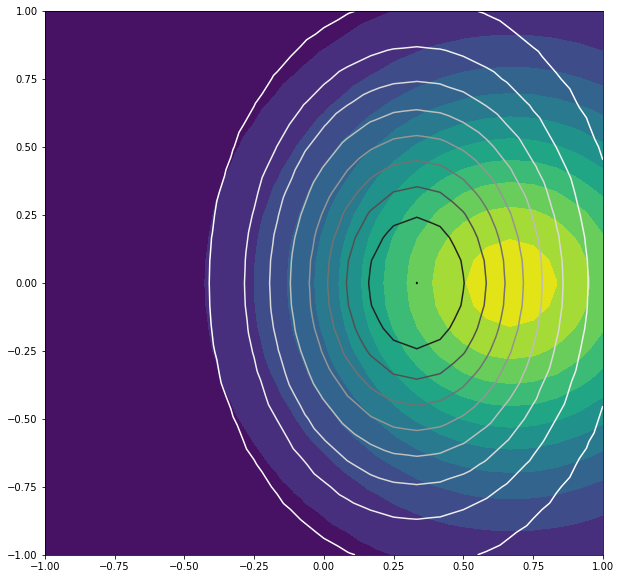

In [96]:
solve_problem(num_samples = 5000,
                num_observations = 1,
                alpha = 0.5, 
                beta = -0.25*0, 
                data_val = -1,
                data_std = 0.25,
                prior_std_1 = 0.5,
                prior_std_2 = 0.5,
                seed=10,
                plot=True)

In [147]:
num_repeats = 20
N_list = [500, 1000, 2500, 5000, 10000]
M_list = [1,2,3,4,5,10,25,50,75,100,150,200,300,400,500]
# M_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
N = 5000
M = 100
data_std = 0.5
prior_std_1, prior_std_2 = 0.25, 0.25


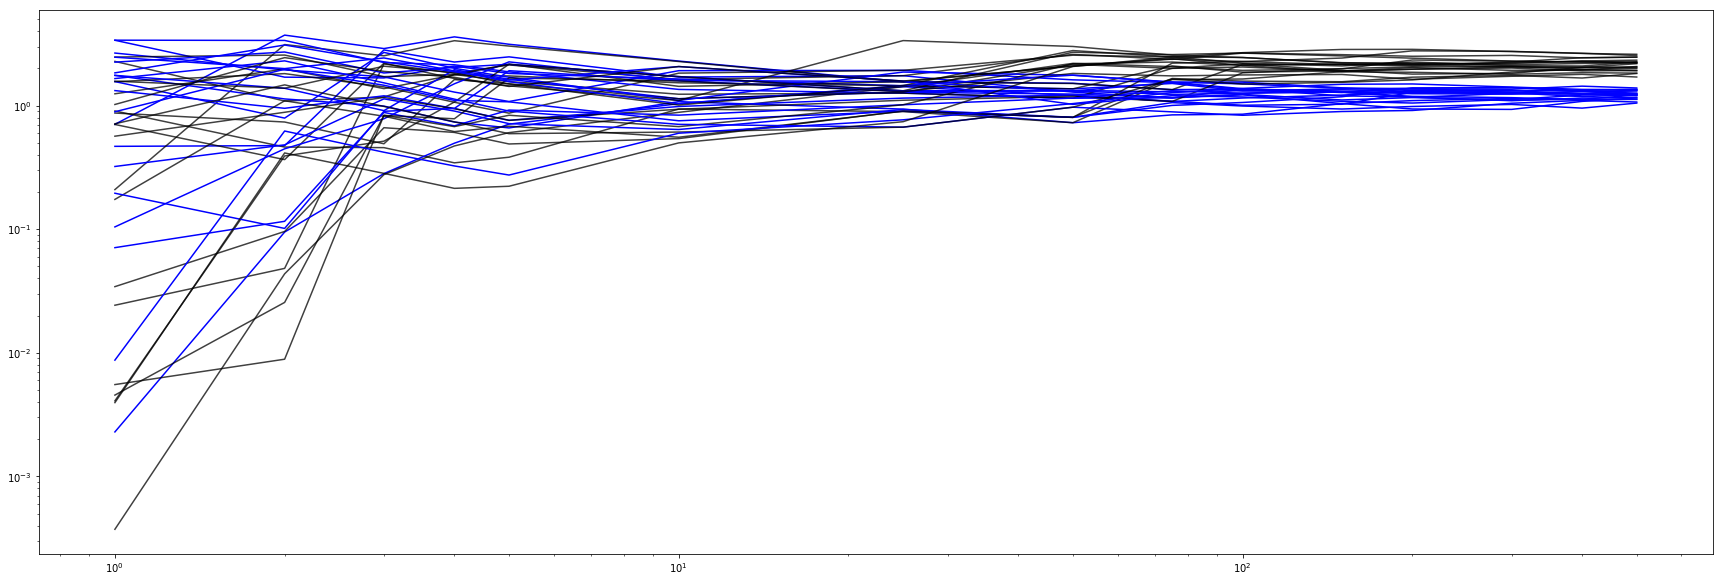

In [148]:
plt.figure(figsize=(30,10))
seed_list = np.random.randint(2,1E4,num_repeats)
for seed in seed_list:
    map_error = []
    map_error_analytical = []
    mud_error = []
#     for N in N_list:
    for M in M_list:
        D = solve_problem(num_samples = N,
                num_observations = M,
                alpha = 0.5, 
                beta = -0.25, 
                data_val = -1,
                data_std = data_std,
                prior_std_1 = prior_std_1,
                prior_std_2 = prior_std_2,
                seed=seed,
                plot=False)
        map_error.append(D['map_error'])
        map_error_analytical.append(D['map_error_analytical'])
        mud_error.append(D['mud_error'])
    plt.plot(M_list, map_error, label='Bayesian', c='b', alpha=1)
#     plt.plot(M_list, map_error_analytical, label='Deterministic', c='r', alpha=1)
    plt.plot(M_list, mud_error, label='Consistent', c='k', alpha=0.75)
plt.xscale('log')
plt.yscale('log')
# plt.ylim([1E-1, 10])
# plt.legend()
plt.show()

# Vary N

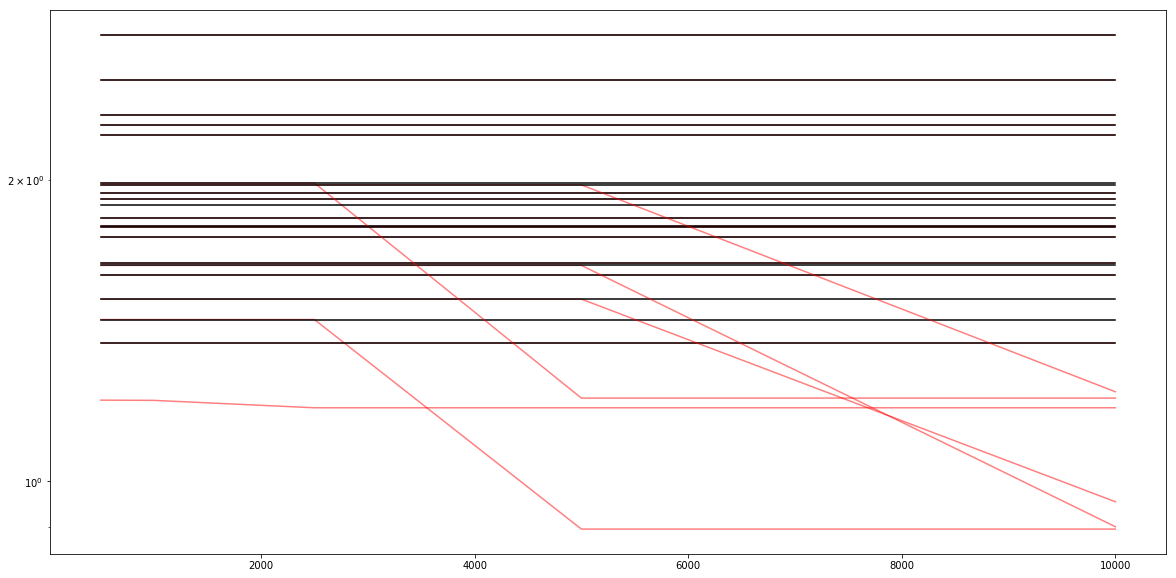

In [146]:
plt.figure(figsize=(20,10))
seed_list = np.random.randint(2,1E4,num_repeats)
for seed in seed_list:
    map_error = []
    map_error_analytical = []
    mud_error = []
    for N in N_list:
        D = solve_problem(num_samples = N,
                num_observations = M,
                alpha = 0.5, 
                beta = -0.25, 
                data_val = -1,
                data_std = 0.1,
                prior_std_1 = prior_std_1,
                prior_std_2 = prior_std_2,
                seed=seed,
                plot=False)
        map_error.append(D['map_error'])
        map_error_analytical.append(D['map_error_analytical'])
        mud_error.append(D['mud_error'])
    plt.plot(N_list, map_error, label='Bayesian', c='r', alpha=0.5)
#     plt.plot(N_list, map_error_analytical, label='Deterministic', c='r', alpha=1)
    plt.plot(N_list, mud_error, label='Consistent', c='k', alpha=1)

plt.yscale('log')
# plt.legend()
plt.show()